In [13]:
# First, run the estimate_transitions notebook to get the learned transition matrices. Then, run this notebook to visualize the errors.

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from matrix_estimation import get_expanded_T
import torch
import warnings

warnings.filterwarnings('ignore')


def plot_summary_df(df, ax, color, label, reps):
    mean = df['mean']
    std = df['std']
    xs = df['N']
    ax.plot(xs, mean, 'o-', color=color, label=label)
    ax.fill_between(xs, mean - (1.69 * std / np.sqrt(reps)), mean + (1.69 *std / np.sqrt(reps)), color=color, alpha=0.1)
    

In [14]:
num_deltas = 10
actions = range(2)
states = range(3)
delta_names = list(range(1, num_deltas + 1))
true_T = np.array([
    [
        [0.89, 0.1, 0.01],
        [0.15, 0.8, 0.05],
        [0.0, 0.0, 1.0]
    ],
    [
        [0.1, 0.89, 0.01],
        [0.8, 0.15, 0.05],
        [0.0, 0.0, 1.0]
    ],
])
true_expanded_T = get_expanded_T(torch.tensor(true_T), len(delta_names))[:, :, :, :]

In [15]:
# reproduce previous stuff

reps = 30
k_to_summary = {}
ks = [1, 2, 5, 10]
for k in ks:
    if k == 10:
        kname = '10_redone3'
    else:
        kname = k
    with open(f'../results/k{kname}.pkl', 'rb') as fin:
        summary = pickle.load(fin)
        k_to_summary[k] = summary
    
    summary = summary['uniform_exhaustive_delays']
    

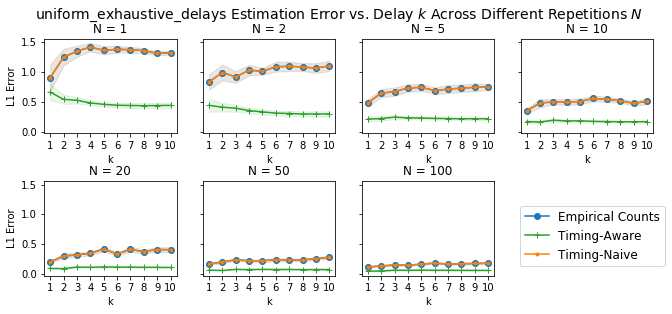

In [109]:
## impact of k on L1 error

exp_name = 'uniform_exhaustive_delays'

Ns = [1, 2, 5, 10, 20, 50, 100]
fig, axes = plt.subplots(len(Ns) //4  + 1, 4, sharey=True, figsize=(3*(len(Ns) //2  + 1)/1.1, (len(Ns) //2  + 1) * 1.2/1.1))

# plot L1 error vs. k for sampling w/ 30 repetitions
for i, N in enumerate(Ns):
    ax = axes[i//4, i % 4]
    ax.set_title(f'N = {N}')
    ax.set_xlabel('k')
    
    xs = []
    means = {}
    stds = {}
    summary = k_to_summary[10][exp_name]
    est_to_est_Ts = {}
    for i, v in enumerate(summary['T_L1_maxs (k = 0)']):
        if N != v['N']:
            continue
        est = v['estimator']
        est_Ts = summary['expanded_est_T'][i]
        est_to_est_Ts[est] = est_Ts
    
    estimator_to_errs = {}
    for estimator, est_Ts in est_to_est_Ts.items():
        errs = []
        for est_T in est_Ts:
            err = (true_expanded_T - est_T).norm(p=1, dim=-2)
            errs.append(err)
        errs = torch.cat([e.unsqueeze(0) for e in errs])
        errs = torch.max(errs, dim=2).values.max(dim=1).values
        means[estimator] = errs.mean(dim=0).tolist()
        stds[estimator] = errs.std(dim=0).tolist()
    xs = range(1, num_deltas + 1)
    
    xticks = [int(x) for x in xs]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
    for (color, label, new_label, marker) in [
        ('tab:blue', 'empirical', 'Empirical Counts', 'o-'),
        ('tab:green', 'smart', 'Timing-Aware', '+-'),
        ('tab:orange', 'dumb', 'Timing-Naive', '.-'),
    ]:
        mean = np.array(means[label])
        std = np.array(stds[label])
        
        ax.plot(xs, mean, marker, color=color, label=new_label)
        ax.fill_between(xs, mean - (1.69 * std / np.sqrt(reps)), mean + (1.69 *std / np.sqrt(reps)), color=color, alpha=0.1)

fig.delaxes(axes[-1, -1])
axes[0,0].set_ylabel('L1 Error')
axes[1,0].set_ylabel('L1 Error')
axes[-1, -2].legend(loc='upper left', bbox_to_anchor=(1.15, 0.8), fontsize=12)
plt.subplots_adjust(hspace=0.5)
plt.suptitle(exp_name + r' Estimation Error vs. Delay $k$ Across Different Repetitions $N$', fontsize=14)
fig.savefig(f'{exp_name}_estimation.pdf', dpi=300)

In [111]:
for i, v in enumerate(k_to_summary[10]['min_delta_delay']['T_L1_maxs (k = 0)']):
    print(v)
    if v['N'] == 10 and v['estimator'] == 'smart':
        print('=========== smart ===========')
        smart_est_T = k_to_summary[10]['min_delta_delay']['expanded_est_T'][i][0]
        print('delay 0')
        print(smart_est_T[:,:,:,0])
        print('delay 1')
        print(smart_est_T[:,:,:,1])
    
    if v['N'] == 10 and v['estimator'] == 'dumb':
        print('=========== dumb ===========')
        dumb_est_T = k_to_summary[10]['min_delta_delay']['expanded_est_T'][i][0]
        print('delay 0')
        print(dumb_est_T[:,:,:,0])
        print('delay 1')
        print(dumb_est_T[:,:,:,1])

{'N': 10, 'mean': 0.315694419046243, 'std': 0.09316103439927387, 'estimator': 'smart'}
=========== smart ===========
delay 0
tensor([[[0.7887, 0.1865, 0.0248],
         [0.1864, 0.7888, 0.0248],
         [0.0000, 0.0000, 1.0000]],

        [[0.2865, 0.6881, 0.0255],
         [0.8901, 0.0874, 0.0225],
         [0.0000, 0.0000, 1.0000]]], grad_fn=<SelectBackward>)
delay 1
tensor([[[0.6568, 0.2942, 0.0490],
         [0.2940, 0.6570, 0.0490],
         [0.0000, 0.0000, 1.0000]],

        [[0.6945, 0.2573, 0.0482],
         [0.3328, 0.6201, 0.0471],
         [0.0000, 0.0000, 1.0000]]], grad_fn=<SelectBackward>)
{'N': 10, 'mean': 0.3154532968997955, 'std': 0.09258650553545572, 'estimator': 'dumb'}
=========== dumb ===========
delay 0
tensor([[[0.7849, 0.1814, 0.0338],
         [0.1813, 0.7849, 0.0338],
         [0.0000, 0.0000, 1.0000]],

        [[0.2815, 0.6833, 0.0352],
         [0.8843, 0.0860, 0.0298],
         [0.0000, 0.0000, 1.0000]]], grad_fn=<SelectBackward>)
delay 1
tensor([[[0.333

In [114]:
formats = {
    'empirical': ('tab:blue', 'Empirical Counts', 'o-'),
    'smart': ('tab:green', 'Timing-Aware', '+-'),
    'dumb': ('tab:orange', 'Timing-Naive', '.-'),
}

In [8]:
## impact of k on L1 error

Ns = [1, 2, 5, 10, 20, 50, 100]

# plot L1 error vs. k for sampling w/ 30 repetitions
N_to_err = {}
for i, N in enumerate(Ns):
    xs = []
    means = {}
    stds = {}
    summary = k_to_summary[10][exp_name]
    est_to_est_Ts = {}
    for i, v in enumerate(summary['T_L1_maxs (k = 0)']):
        if N != v['N']:
            continue
        est = v['estimator']
        est_Ts = summary['expanded_est_T'][i]
        est_to_est_Ts[est] = est_Ts
    
    estimator_to_errs = {}
    for estimator, est_Ts in est_to_est_Ts.items():
        errs = []
        for est_T in est_Ts:
            err = (true_expanded_T - est_T).norm(p=1, dim=-2)
            errs.append(err)
        errs = torch.cat([e.unsqueeze(0) for e in errs])
        errs = torch.max(errs, dim=2).values.max(dim=1).values
        means[estimator] = errs.mean(dim=0).tolist()
        stds[estimator] = errs.std(dim=0).tolist()
    N_to_err[N] = {'means': means, 'stds': stds}


In [233]:
def plot_est_err_vs_N(exp_name):
    names = {
        'min_delta_delay': [
            'err_min_delta.pdf', 
            r'Estimation error from samples where delay $k = \min(\mathcal{K})$ = 1',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [10, 20, 50, 100, 200, 500, 1000],
        ],
        'max_delta_delay': [
            'err_max_delta.pdf', 
            r'Estimation error from samples where delay $k = \max(\mathcal{K})$ = 10',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [10, 20, 50, 100, 200, 500, 1000],
        ],
        'uniform_exhaustive_delays': [
            'err_exhaustive_delta.pdf', 
            r'Estimation error from samples where delay $k \in \mathcal{K}$ = [1, 2, ..., 10]',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [1, 2, 5, 10, 20, 50, 100],
        ]
    }[exp_name]
    
    fname, plt_title, ylabel, Ns = names
    
    ## impact of k on L1 error

    # plot L1 error vs. k for sampling w/ 30 repetitions
    N_to_err = {}
    for i, N in enumerate(Ns):
        xs = []
        means = {}
        stds = {}
        summary = k_to_summary[10][exp_name]
        est_to_est_Ts = {}
        for i, v in enumerate(summary['T_L1_maxs (k = 0)']):
            if N != v['N']:
                continue
            est = v['estimator']
            est_Ts = summary['expanded_est_T'][i]
            est_to_est_Ts[est] = est_Ts

        estimator_to_errs = {}
        for estimator, est_Ts in est_to_est_Ts.items():
            errs = []
            for est_T in est_Ts:
                err = (true_expanded_T - est_T).norm(p=1, dim=-2)
                errs.append(err)
            errs = torch.cat([e.unsqueeze(0) for e in errs])
            errs = torch.max(errs, dim=2).values.max(dim=1).values
            means[estimator] = errs.mean(dim=0).tolist()
            stds[estimator] = errs.std(dim=0).tolist()
        N_to_err[N] = {'means': means, 'stds': stds}

    to_plot = []
    ks_to_plot = [1, 5, 10]
    fig, ax = plt.subplots(1,len(ks_to_plot), sharey=True, figsize=(len(ks_to_plot)*3, 3))
    for N, err in N_to_err.items():
        for estimator in err['means']:
            mean = err['means'][estimator]
            std = err['stds'][estimator]

            for k in ks_to_plot:
                to_plot.append([N, estimator, mean[k-1], std[k-1], k])
                
    to_plot = pd.DataFrame(to_plot, columns=['N', 'estimator', 'mean', 'std', 'k'])
    k_plots = {k: to_plot[to_plot['k'] == k].drop('k', axis=1) for k in ks_to_plot}
    estimators = ['empirical', 'dumb', 'smart']
    for estimator in estimators:
        for i, (k, k_plot) in enumerate(k_plots.items()):
            group_df = k_plot[k_plot['estimator'] == estimator]
            print(group_df,  k)
            color, title, markerstyle = formats[estimator]
#             x = group_df['N']
            x = [int(x) * 60 for x in [1, 2, 5, 10, 20, 50, 100]]
            ax[i].plot(x, group_df['mean'], markerstyle, label=title, color=color)
            ax[i].fill_between(x, 
                            group_df['mean'] - (1.69 * group_df['std'] / np.sqrt(reps)), 
                            group_df['mean'] + (1.69 * group_df['std'] / np.sqrt(reps)), 
                            color=color, alpha=0.1)
            ax[i].set_title(f'k = {k}')
            ax[i].set_xscale('log')
            ax[i].set_xlabel('N')
            ax[i].set_xlim(0, 1e4)
    ax[0].set_ylabel(ylabel) 
    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.subplots_adjust(top=0.75) 
    plt.suptitle(plt_title, fontsize=14, x=0.43)
    fig.savefig(fname, dpi=300)


In [9]:
exp_names = [
    'min_delta_delay',
    'max_delta_delay',
    'uniform_exhaustive_delays',
]
for exp_name in exp_names:
    print(f'======== {exp_name} =======')
    plot_est_err_vs_N(exp_name)

In [201]:
def plot_est_err_vs_N(exp_name, ks_to_plot, ax):
    names = {
        'min_delta_delay': [
            'err_min_delta.pdf', 
            r'$k = \min(\mathcal{K})$ = 1',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [10, 20, 50, 100, 200, 500, 1000],
        ],
        'max_delta_delay': [
            'err_max_delta.pdf', 
            r'$k = \max(\mathcal{K})$ = 10',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [10, 20, 50, 100, 200, 500, 1000],
        ],
        'uniform_exhaustive_delays': [
            'err_exhaustive_delta.pdf', 
            r'$k \in \mathcal{K}$ = [1, 2, ..., 10]',
            'Estimation error\n' + r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$',
            [1, 2, 5, 10, 20, 50, 100],
        ]
    }[exp_name]
    
    fname, plt_title, _, Ns = names
    
    ax[0].set_title('Sample delay\n ' + plt_title, fontsize=14)
    
    ## impact of k on L1 error

    # plot L1 error vs. k for sampling w/ 30 repetitions
    N_to_err = {}
    for i, N in enumerate(Ns):
        xs = []
        means = {}
        stds = {}
        summary = k_to_summary[10][exp_name]
        est_to_est_Ts = {}
        for i, v in enumerate(summary['T_L1_maxs (k = 0)']):
            if N != v['N']:
                continue
            est = v['estimator']
            est_Ts = summary['expanded_est_T'][i]
            est_to_est_Ts[est] = est_Ts

        estimator_to_errs = {}
        for estimator, est_Ts in est_to_est_Ts.items():
            errs = []
            for est_T in est_Ts:
                err = (true_expanded_T - est_T).norm(p=1, dim=-2)
                errs.append(err)
            errs = torch.cat([e.unsqueeze(0) for e in errs])
            errs = torch.max(errs, dim=2).values.max(dim=1).values
            means[estimator] = errs.mean(dim=0).tolist()
            stds[estimator] = errs.std(dim=0).tolist()
        N_to_err[N] = {'means': means, 'stds': stds}

    to_plot = []
    for N, err in N_to_err.items():
        for estimator in err['means']:
            mean = err['means'][estimator]
            std = err['stds'][estimator]

            for k in ks_to_plot:
                to_plot.append([N, estimator, mean[k-1], std[k-1], k])

    to_plot = pd.DataFrame(to_plot, columns=['N', 'estimator', 'mean', 'std', 'k'])
    k_plots = {k: to_plot[to_plot['k'] == k].drop('k', axis=1) for k in ks_to_plot}
    estimators = ['empirical', 'dumb', 'smart']
    for estimator in estimators:
        for i, (k, k_plot) in enumerate(k_plots.items()):
            group_df = k_plot[k_plot['estimator'] == estimator]
            color, title, markerstyle = formats[estimator]
            x = [int(x) * 60 for x in [1, 2, 5, 10, 20, 50, 100]]
            ax[i].plot(x, group_df['mean'], markerstyle, label=title, color=color)
            ax[i].fill_between(x, 
                            group_df['mean'] - (1.69 * group_df['std'] / np.sqrt(reps)), 
                            group_df['mean'] + (1.69 * group_df['std'] / np.sqrt(reps)), 
                            color=color, alpha=0.1)

            ax[i].set_xscale('log')
            ax[i].set_xlim(0, 1e4)


In [ ]:
ks_to_plot = [1, 5, 10]

fig, ax = plt.subplots(3,len(ks_to_plot), sharey=True, sharex=True, figsize=(len(ks_to_plot)*2.7, 2*3))
exp_names = [
    'uniform_exhaustive_delays',
    'min_delta_delay',
    'max_delta_delay',
]
for i, exp_name in enumerate(exp_names):
    print(f'======== {exp_name} =======')
    plot_est_err_vs_N(exp_name, ks_to_plot, ax[:, i])

fig.text(
    0, 0.5, 
    r'$\max_{a, s}|| P_{a, k}(\cdot | s) - \widehat{P}_{a, k}(\cdot | s) ||_1$ for various $k$', 
    va='center', rotation='vertical',
    fontsize=16
)

for i, k in enumerate(ks_to_plot):
    ax[i,0].set_ylabel(f'k = {k}', fontsize=14, fontweight='bold')
    ax[-1, i].set_xlabel('N', fontsize=16)

plt.subplots_adjust(bottom=0.16, top=0.85, wspace=0.1, hspace=0.1)  # Adjust the space at the bottom
ax[-1][-2].legend(loc='upper center', bbox_to_anchor=(0.35, -0.4), ncol=3, fontsize=14)

plt.suptitle("Estimation error vs. # samples, for different sampling regimes", fontsize=16, y=1, x=0.45)
plt.savefig('estimation_error.pdf', dpi=300)